In [371]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

plt.style.use("default")
plt.rcParams.update({"xtick.top": True          , "ytick.right": True,
                     "xtick.minor.visible": True, "ytick.minor.visible": True,
                     "xtick.direction": "in"    , "ytick.direction": "in",
                     "axes.labelsize": "large", "text.usetex": True})

In [372]:
# (a)
data = pd.read_csv("AbschirmungVonRoentgenstrahlung.csv",
                   delimiter='\t',
                   usecols=[f"N_{i}" for i in range(1, 10)])
data = np.array(data).T

settings = pd.read_csv("Settings.csv", delimiter=';')

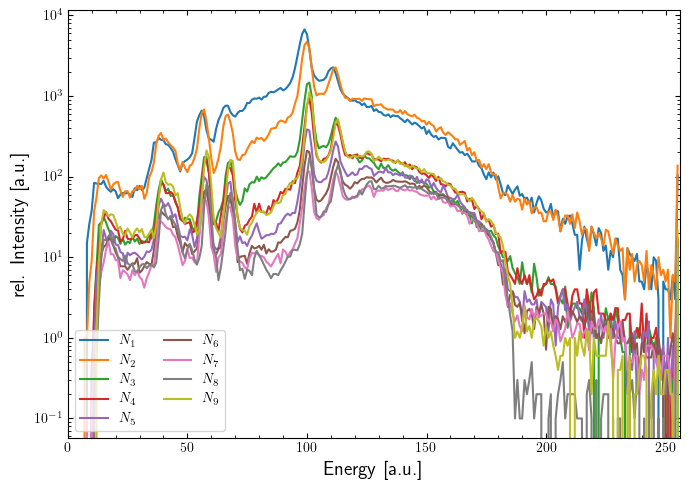

In [373]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

for i in range(len(data)):
    Y = data[i] / settings.iloc[i,3] / settings.iloc[i,-1]
    X = np.arange(len(Y))
    ax.plot(X,Y,label=f"$N_{settings.iloc[i,0]}$")
    ax.set_yscale("log")
ax.legend(ncols=2, loc="lower left")
ax.set_xlabel("Energy [a.u.]", fontsize=14)
ax.set_ylabel("rel. Intensity [a.u.]", fontsize=14)
ax.set_xlim(0,len(data[0]))

fig.savefig("a.svg")

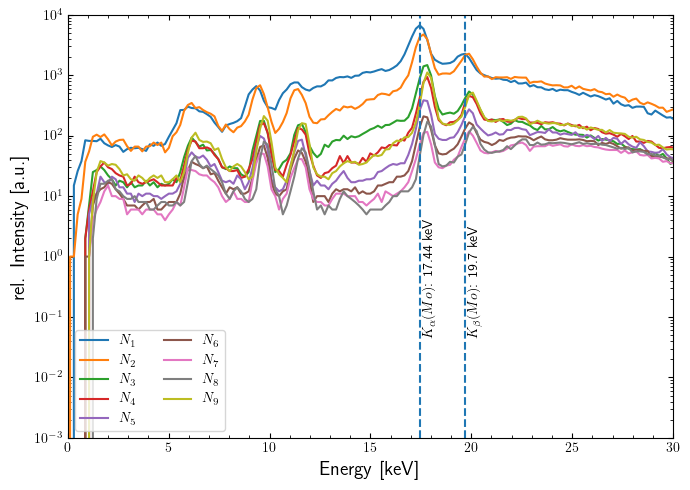

In [374]:
# (b)
E_K_alpha, E_K_beta = 17.44, 19.7 # keV
peaks, _ = find_peaks(data[0],)
peaks = np.vstack((peaks, data[0][peaks])).T
K_beta, K_alpha = sorted(peaks, key=lambda x: x[1])[-2:]
K_alpha, K_beta = K_alpha[0], K_beta[0]

x_scale = (E_K_beta - E_K_alpha) / (K_beta - K_alpha) # keV / n 
x_offset = E_K_alpha - x_scale * K_alpha # keV

X = np.arange(len(data[0])) * x_scale + x_offset
Y = data.copy()
for i in range(len(data)):
    Y[i] = Y[i]/settings.iloc[i,3] / settings.iloc[i,-1]

fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

for i in range(len(data)):
    ax.plot(X,Y[i],label=f"$N_{i+1}$")
    ax.set_yscale("log")

ax.axvline(E_K_alpha, linestyle="--")# label = "$K_\\alpha$"
ax.axvline(E_K_beta, linestyle="--")#, label = "$K_\\beta$", c="g"
ax.text(E_K_alpha+.1, 5e-2, f"$K_\\alpha(Mo)$: {E_K_alpha} keV",rotation=90)
ax.text(E_K_beta+.1, 5e-2, f"$K_\\beta(Mo)$: {E_K_beta} keV",rotation=90)

ax.legend(ncols=2, loc="lower left")
ax.set_xlabel("Energy [keV]", fontsize=14)
ax.set_ylabel("rel. Intensity [a.u.]", fontsize=14)
ax.set_xlim(0,30)
ax.set_ylim(1e-3,1e4)
fig.savefig("b.svg")

In [436]:
from scipy.optimize import curve_fit 

cutoff = 3
Y_ = Y[cutoff:]
d = np.array(settings.iloc[cutoff:,-2])
keV = (15,25)
n = lambda E: int((E-x_offset) / x_scale)
YE = [[y[n(keV)] for y in Y_ ]for keV in keV]

f = lambda d,a,b: a*np.exp(-b*d)
fits = [curve_fit(f, d, y)[0] for y in YE]

# fig, axes = plt.subplots(2,1,figsize=(7,7), tight_layout=True, sharex=True)
# for i in range(2):
#     axes[i].scatter(d, YE[i], marker="+")
#     axes[i].plot(x:=np.linspace(min(d),max(d), 50), f(x, *fits[i]))
#     axes[i].set_ylabel(f"rel. Intensity at {keV[i]} keV [a.u.]",fontsize=14)
#     axes[i].set_title(f"{keV[i]} keV, fit $= {fits[i][0]:.3f}\\cdot e^{{{-fits[i][1]:.3}\\cdot x}}$")
# fig.supxlabel("Absorber thickness [mm]",fontsize=14)
# fig.savefig("c.svg")

# literature values: 
rho_Al = 2.7 # g/cm³ (20°C)
mu_15keV_lit, mu_25keV_lit = 7.955 * rho_Al, (3.441+1.128)/2 * rho_Al # cm²/g 

# experimental values
mu_15keV, mu_25keV= fits[0][1] * 1e1, fits[1][1] * 1e1 # cm²/g  

print(
f"""{"":=<57}
{"Größe [cm²/g]":<15}{"Experimentell":<15}{"Literatur":<11} {"rel. Abweichung":<15}
{"":-<57}
{"mu_15keV":<15}{mu_15keV:<15.3}{mu_15keV_lit:<11.3}{mu_15keV/mu_15keV_lit-1:<15.3}
{"mu_25keV":<15}{mu_25keV:<15.3}{mu_25keV_lit:<11.3}{mu_25keV/mu_25keV_lit-1:<15.3}
{"":=<57}""")

""" 
outputs:
=========================================================
Größe [cm²/g]  Experimentell  Literatur   rel. Abweichung
---------------------------------------------------------
mu_15keV       20.9           21.5       -0.0257        
mu_25keV       8.36           6.17       0.355          
=========================================================

bzw. ohne die ersten drei Datenpunkte:
=========================================================
Größe [cm²/g]  Experimentell  Literatur   rel. Abweichung
---------------------------------------------------------
mu_15keV       14.7           21.5       -0.315         
mu_25keV       4.96           6.17       -0.196         
=========================================================
"""



Größe [cm²/g]  Experimentell  Literatur   rel. Abweichung
---------------------------------------------------------
mu_15keV       14.7           21.5       -0.315         
mu_25keV       4.96           6.17       -0.196         


' \noutputs:\n=========================================================\nGröße [cm²/g]  Experimentell  Literatur   rel. Abweichung\n---------------------------------------------------------\nmu_15keV       20.9           21.5       -0.0257        \nmu_25keV       8.36           6.17       0.355          \n=========================================================\n'